In [34]:
import json
import pandas as pd
import matplotlib.pyplot as plt

websockets_har_path = "./chess-p3.har"
ajax_har_path = "./chess-p2.har"

with open(websockets_har_path, 'r') as file:
    websockets_har_data = json.load(file)

with open(ajax_har_path, 'r') as file:
    ajax_har_data = json.load(file)


websocket_entries = [
    entry for entry in websockets_har_data['log']['entries'] if entry.get("_resourceType") == "websocket"
]


websocket_message_data = []
for entry in websocket_entries:
    web_socket_messages = entry.get("_webSocketMessages", [])
    for message in web_socket_messages:
        time = message.get("time")
        opcode = message.get("opcode")
        data = message.get("data", "{}")
        _type = message.get("type")
        action = None
        try:
            action_data = json.loads(data)
            action = action_data.get("action") if action_data.get("action") is not None else action_data.get("type")
        except (json.JSONDecodeError, TypeError):
            pass

        websocket_message_data.append({
            "Time (ms)": time,
            "Opcode": opcode,
            "Action": action,
            "Data": data,
            "Type": _type
        })


websocket_message_df = pd.DataFrame(websocket_message_data)


send_messages = websocket_message_df[websocket_message_df["Type"] == "send"].reset_index(drop=True)
receive_messages = websocket_message_df[websocket_message_df["Type"] == "receive"].reset_index(drop=True)

matched_messages = []
for _, send_msg in send_messages.iterrows():
    receive_msg = receive_messages.loc[
        (receive_messages["Time (ms)"] > send_msg["Time (ms)"])
    ].head(1)  # Find the first "receive" message after the "send"

    if not receive_msg.empty:
        receive_msg = receive_msg.iloc[0]
        matched_messages.append({
            "Send Time (ms)": send_msg["Time (ms)"],
            "Receive Time (ms)": receive_msg["Time (ms)"],
            "Latency (ms)": receive_msg["Time (ms)"] - send_msg["Time (ms)"],
            "Action": send_msg["Action"]
        })

# Calculate latency
# matched_messages["Latency (ms)"] = matched_messages["Receive Time (ms)"] - matched_messages["Send Time (ms)"]
matched_messages_df = pd.DataFrame(matched_messages)

websocket_summary = matched_messages_df.groupby("Action").agg(
    Mean_Latency=("Latency (ms)", "mean"),
    Median_Latency=("Latency (ms)", "median"),
    Count=("Latency (ms)", "count")
).reset_index()



In [21]:
websocket_summary

,Action,Mean_Latency,Median_Latency,Count
0,game_resigned,-94.519989,-94.519989,1
1,get_available_players,-47.400854,-47.400854,2
2,get_challenges,-47.431049,-47.431049,2
3,move,-107.847599,-105.055400,4
4,send_challenge,-61.299501,-61.299501,1


In [37]:
ajax_entries = ajax_har_data['log']['entries']
ajax_request_data = []
for entry in ajax_entries:
    request_url = entry['request']['url']
    method = entry['request']['method']
    status = entry['response']['status']
    timings = entry['timings']
    time = entry['time']
    action = None
    try:
        request_body = entry['request'].get('postData', {}).get('text', "{}")
        action_data = json.loads(request_body)
        action = action_data.get("action", None)
    except (json.JSONDecodeError, TypeError):
        pass

    ajax_request_data.append({
        "Endpoint": request_url,
        "Method": method,
        "Action": action,
        "Status": status,
        "Total Time (ms)": time,
        "Blocked (ms)": timings.get('blocked', None),
        "Wait (ms)": timings.get('wait', None),
        "Receive (ms)": timings.get('receive', None)
    })

ajax_request_df = pd.DataFrame(ajax_request_data)

ajax_summary = ajax_request_df.groupby(
    ["Endpoint", "Method"]
).agg(
    Mean_Latency=("Total Time (ms)", "mean"),
    Median_Latency=("Total Time (ms)", "median"),
    Count=("Total Time (ms)", "count")
).reset_index()

                Metric  WebSocket       AJAX
0    Mean Latency (ms)   0.495465  79.170556
1  Median Latency (ms)   0.048163  77.340500
2        Request Count  10.000000  73.000000


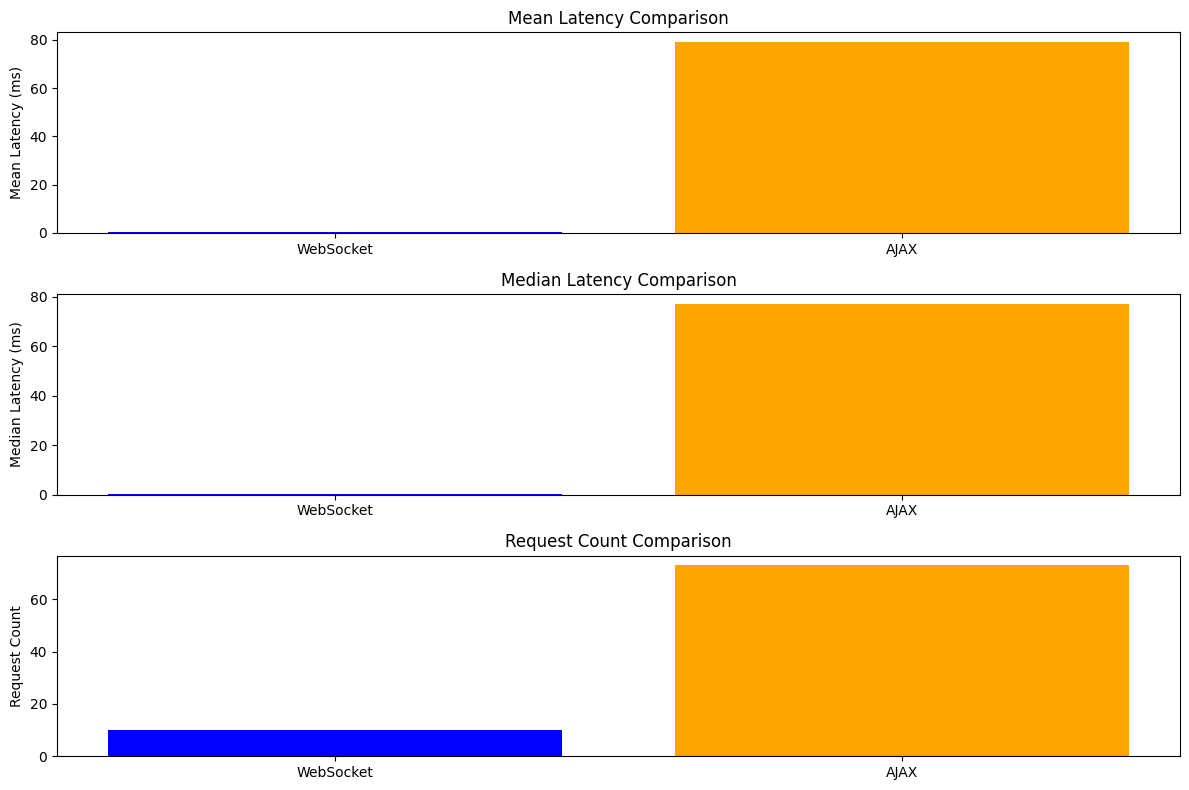

In [45]:
comparison_table = pd.DataFrame({
    "Metric": ["Mean Latency (ms)", "Median Latency (ms)", "Request Count"],
    "WebSocket": [
        websocket_summary["Mean_Latency"].mean(),
        websocket_summary["Median_Latency"].median(),
        websocket_summary["Count"].sum()
    ],
    "AJAX": [
        ajax_summary["Mean_Latency"].mean(),
        ajax_summary["Median_Latency"].median(),
        ajax_summary["Count"].sum()
    ]
})

print(comparison_table)

In [53]:
websocket_summary

,Action,Mean_Latency,Median_Latency,Count
0,game_resigned,0.048163,0.048163,1
1,get_available_players,0.032339,0.032339,2
2,get_challenges,0.032349,0.032349,2
3,move,0.057564,0.054376,4
4,send_challenge,2.306911,2.306911,1


In [64]:
websocket_custom_groups = {
    "game/75/status/": ["get_available_players", "get_challenges"],
    "game/75/update_board/": ["move", "game_resigned"],
    "game/75/": ["send_challenge"]
}

websocket_custom_summary = []
for endpoint, actions in websocket_custom_groups.items():
    filtered = websocket_summary[websocket_summary["Action"].isin(actions)]
    websocket_custom_summary.append({
        "Endpoint": endpoint,
        "Action": ', '.join(filtered['Action']),
        "Mean Latency (ms)": filtered["Mean_Latency"].mean(),
        "Median Latency (ms)": filtered["Median_Latency"].median(),
        "Request Count": filtered["Count"].sum()
    })

websocket_custom_summary_df = pd.DataFrame(websocket_custom_summary)

In [65]:
websocket_custom_summary_df

,Endpoint,Action,Mean Latency (ms),Median Latency (ms),Request Count
0,game/75/status/,"get_available_players, get_challenges",0.032344,0.032344,4
1,game/75/update_board/,"game_resigned, move",0.052863,0.051270,5
2,game/75/,send_challenge,2.306911,2.306911,1


                                  Action  WebSocket Mean Latency (ms)  \
0  get_available_players, get_challenges                     0.032344   
1                    game_resigned, move                     0.052863   
2                         send_challenge                     2.306911   

   WebSocket Median Latency (ms)  WebSocket Request Count  \
0                       0.032344                        4   
1                       0.051270                        5   
2                       2.306911                        1   

                Endpoint  AJAX Mean Latency (ms)  AJAX Median Latency (ms)  \
0        game/75/status/               79.882554                   77.3405   
1  game/75/update_board/               75.618400                   74.6840   
2               game/75/               82.010714                   81.3510   

   AJAX Request Count  
0                  56  
1                  10  
2                   7  


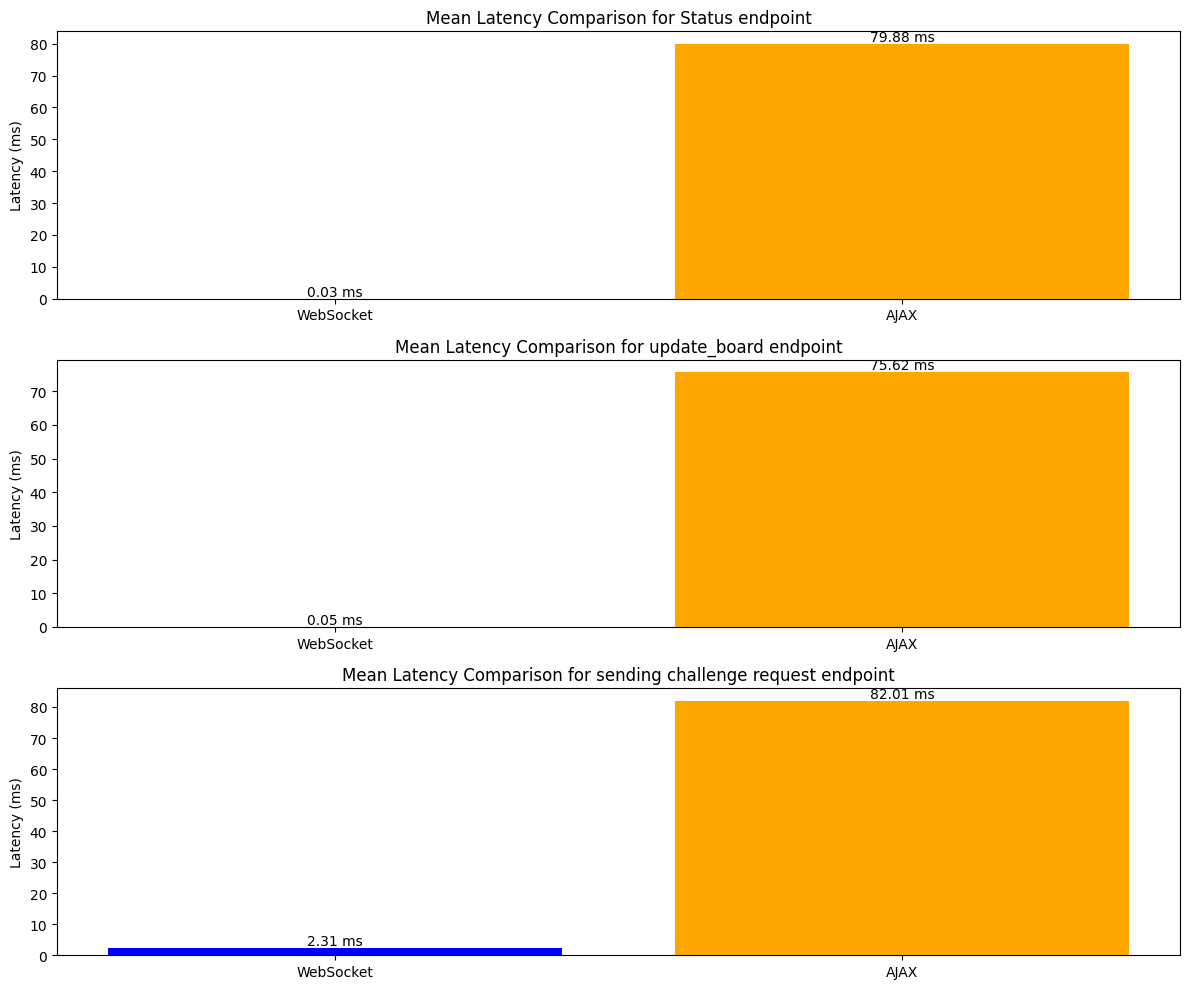

In [81]:
ajax_custom_groups = {
    "game/75/status/": "GET",
    "game/75/update_board/": "GET",
    "game/75/": "POST"
}

ajax_custom_summary = []
for endpoint, method in ajax_custom_groups.items():
    filtered = ajax_summary[(ajax_summary["Endpoint"].str.contains(endpoint)) & (ajax_summary["Method"] == method)]
    ajax_custom_summary.append({
        "Endpoint": endpoint,
        "Mean Latency (ms)": filtered["Mean_Latency"].mean(),
        "Median Latency (ms)": filtered["Median_Latency"].median(),
        "Request Count": filtered["Count"].sum()
    })

ajax_custom_summary_df = pd.DataFrame(ajax_custom_summary)


comparison_table = pd.concat([
    websocket_custom_summary_df[['Action', 'Mean Latency (ms)', 'Median Latency (ms)', 'Request Count']].rename(columns={
        "Mean Latency (ms)": "WebSocket Mean Latency (ms)",
        "Median Latency (ms)": "WebSocket Median Latency (ms)",
        "Request Count": "WebSocket Request Count"
    }),
    ajax_custom_summary_df.rename(columns={
        "Mean Latency (ms)": "AJAX Mean Latency (ms)",
        "Median Latency (ms)": "AJAX Median Latency (ms)",
        "Request Count": "AJAX Request Count"
    })
], axis=1)

print(comparison_table)


plt.figure(figsize=(12, 10))

# Mean Latency Comparison fpr status endpoint
plt.subplot(3, 1, 1)
bar_labels = ["WebSocket", "AJAX"]
bar_values = [
    comparison_table["WebSocket Mean Latency (ms)"].where(comparison_table["Endpoint"] == "game/75/status/").mean(),
    comparison_table["AJAX Mean Latency (ms)"].where(comparison_table["Endpoint"] == "game/75/status/").mean()
]

bars = plt.bar(bar_labels, bar_values, color=['blue', 'orange'])

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{height:.2f} ms',
        ha='center',
        va='bottom'
    )


plt.title("Mean Latency Comparison for Status endpoint")
plt.ylabel("Latency (ms)")

# Mean Latency Comparison of update_board
plt.subplot(3, 1, 2)
bar_labels = ["WebSocket", "AJAX"]
bar_values = [
    comparison_table["WebSocket Mean Latency (ms)"].where(comparison_table["Endpoint"] == "game/75/update_board/").mean(),
    comparison_table["AJAX Mean Latency (ms)"].where(comparison_table["Endpoint"] == "game/75/update_board/").mean()
]

bars = plt.bar(bar_labels, bar_values, color=['blue', 'orange'])

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{height:.2f} ms',
        ha='center',
        va='bottom'
    )


plt.title("Mean Latency Comparison for update_board endpoint")
plt.ylabel("Latency (ms)")

# Request Count Comparison game/75/
plt.subplot(3, 1, 3)
bar_labels = ["WebSocket", "AJAX"]
bar_values = [
    comparison_table["WebSocket Mean Latency (ms)"].where(comparison_table["Endpoint"] == "game/75/").mean(),
    comparison_table["AJAX Mean Latency (ms)"].where(comparison_table["Endpoint"] == "game/75/").mean()
]


bars = plt.bar(bar_labels, bar_values, color=['blue', 'orange'])

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{height:.2f} ms',
        ha='center',
        va='bottom'
    )


plt.title("Mean Latency Comparison for sending challenge request endpoint")
plt.ylabel("Latency (ms)")

plt.tight_layout()
plt.show()

In [74]:
comparison_table["WebSocket Mean Latency (ms)"].where(comparison_table["Endpoint"]=="game/75/status/").mean()

0.03234374523162842

In [71]:
comparison_table

,Action,WebSocket Mean Latency (ms),WebSocket Median Latency (ms),WebSocket Request Count,Endpoint,AJAX Mean Latency (ms),AJAX Median Latency (ms),AJAX Request Count
0,"get_available_players, get_challenges",0.032344,0.032344,4,game/75/status/,79.882554,77.3405,56
1,"game_resigned, move",0.052863,0.051270,5,game/75/update_board/,75.618400,74.6840,10
2,send_challenge,2.306911,2.306911,1,game/75/,82.010714,81.3510,7
